# Telecom Megaline Statistical Data Analysis
Project Report by Allentine Paulis

# Table of Contents
* [Project Description](#description)
    * [Description of the plans](#plandescription)
    * [Surf](#surfdesc)
    * [Ultimate](#ultimatedesc)
* [Data](#data)
* [Step 1. Understanding Data](#understanding)
    * [Study the general information : Megaline Calls](#studycalls)
    * [Study the general information : Megaline Internet](#studyinternet)
    * [Study the general information : Megaline Messages](#studymessages)
    * [Study the general information : Megaline Plans](#studyplans)
    * [Study the general information : Megaline Users](#studyusers)
* [Step 2. Data Preprocessing](#preprocessing)
    * [Q1. The number of calls made and minutes used per month](#q1)
    * [Q2. The number of text messages sent per month](#q2)
    * [Q3. The volume of data per month](#q3)
    * [Q4. The monthly revenue from each user](#q4)    
* [Step 3. Exploratory data analysis](#eda)
* [Step 4. Hypotheses Testing](#hypotest)
    * [Hypothesis 1](#hypo1)
    * [Hypothesis 2](#hypo2)
* [Step 5. Overall conclusion](#allconclusion)

# Project Description <a class="anchor" id="description"></a>

As an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. The task is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

### Description of the plan  <a class="anchor" id="plandescription"></a>

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For **calls**, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For **web traffic**, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

### Surf <a class="anchor" id="surfdesc"></a>

1. Monthly charge: $20

2. 500 monthly minutes, 50 texts, and 15 GB of data

3. After exceeding the package limits:
    * 1 minute: 3 cents
    * 1 text message: 3 cents
    * 1 GB of data: $10

### Ultimate <a class="anchor" id="ultimatedesc"></a>

1. Monthly charge: $70

2. 3000 monthly minutes, 1000 text messages, and 30 GB of data

3. After exceeding the package limits:
    * 1 minute: 1 cent
    * 1 text message: 1 cent
    * 1 GB of data: $7

# Data <a class="anchor" id="data"></a>

The `users` table (data on users):
- *user_id* — unique user identifier
- *first_name* — user's name
- *last_name* — user's last name
- *age* — user's age (years)
- *reg_date* — subscription date (dd, mm, yy)
- *churn_date* — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- *city* — user's city of residence
- *plan* — calling plan name


The `calls` table (data on calls):
- *id* — unique call identifier
- *call_date* — call date
- *duration* — call duration (in minutes)
- *user_id* — the identifier of the user making the call


The `messages` table (data on texts):
- *id* — unique text message identifier
- *message_date* — text message date
- *user_id* — the identifier of the user sending the text


The `internet` table (data on web sessions):
- *id* — unique session identifier
- *mb_used* — the volume of data spent during the session (in megabytes)
- *session_date* — web session date
- *user_id* — user identifier


The `plans` table (data on the plans):
- *plan_name* — calling plan name
- *usd_monthly_fee* — monthly charge in US dollars
- *minutes_included* — monthly minute allowance
- *messages_included* — monthly text allowance
- *mb_per_month_included* — data volume allowance (in megabytes)
- *usd_per_minute* — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- *usd_per_message* — price per text after exceeding the package limits
- *usd_per_gb* — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Step 1. Understanding Data  <a class="anchor" id="understanding"></a>

In [383]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as mt
from scipy import stats as st
import seaborn as sns

In [384]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_messages.csv')
plans = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_plans.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_users.csv')

### Study the general information : Megaline Calls <a class="anchor" id="studycalls"> </a>

In [385]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [386]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


* call_date data type supposed to be datetime

In [387]:
calls.describe(include='all')

,id,user_id,call_date,duration
count,137735,137735.000000,137735,137735.000000
unique,137735,NaN,351,NaN
top,1203_224,NaN,2018-12-27,NaN
freq,1,NaN,1091,NaN
mean,NaN,1247.658046,NaN,6.745927
std,NaN,139.416268,NaN,5.839241
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1128.000000,NaN,1.290000
50%,NaN,1247.000000,NaN,5.980000
75%,NaN,1365.000000,NaN,10.690000


- There is 0 minimum calls duration, maybe it can be classified as missed call

In [388]:
calls.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [389]:
calls.duplicated().sum()

0

In [390]:
calls['id'].nunique() == len(calls)

True

- calls id is unique

In [391]:
calls['user_id'].nunique()

481

- There are 481 unique users in calls

### Study the general information : Megaline Internet <a class="anchor" id="studyinternet"> </a>

In [392]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [393]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


- session_data data types supposed to be datetime

In [394]:
internet.describe(include='all')

,id,user_id,session_date,mb_used
count,104825,104825.000000,104825,104825.000000
unique,104825,NaN,351,NaN
top,1203_224,NaN,2018-12-24,NaN
freq,1,NaN,851,NaN
mean,NaN,1242.496361,NaN,366.713701
std,NaN,142.053913,NaN,277.170542
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1122.000000,NaN,136.080000
50%,NaN,1236.000000,NaN,343.980000
75%,NaN,1367.000000,NaN,554.610000


- There is 0 mb_used, maybe the users use WiFi not this regular internet connection.

In [395]:
internet.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [396]:
internet.duplicated().sum()

0

In [397]:
internet['id'].nunique() == len(internet)

True

- Internet id is unique

In [398]:
internet['user_id'].nunique()

489

- There is 489 unique users using internet

### Study the general information : Megaline Messages <a class="anchor" id="studymessages"> </a>

In [399]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [400]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


- message_date data types supposed to be datetime

In [401]:
messages.describe(include='all')

,id,user_id,message_date
count,76051,76051.000000,76051
unique,76051,NaN,351
top,1381_295,NaN,2018-12-28
freq,1,NaN,702
mean,NaN,1245.972768,NaN
std,NaN,139.843635,NaN
min,NaN,1000.000000,NaN
25%,NaN,1123.000000,NaN
50%,NaN,1251.000000,NaN
75%,NaN,1362.000000,NaN


In [402]:
messages.isna().sum()

id              0
user_id         0
message_date    0
dtype: int64

In [403]:
messages.duplicated().sum()

0

In [404]:
messages['id'].nunique() == len(messages)

True

- There is unique id in messages

In [405]:
messages['user_id'].nunique()

402

- There is 402 unique users using messages

### Study the general information : Megaline Plans <a class="anchor" id="studyplans"> </a>

In [406]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [407]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


### Study the general information : Megaline Users <a class="anchor" id="studyusers"> </a>

In [408]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [409]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


- reg_date data types supposed to be datetime

In [410]:
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [411]:
users.isna().sum() * 100/len(users)

user_id        0.0
first_name     0.0
last_name      0.0
age            0.0
city           0.0
reg_date       0.0
plan           0.0
churn_date    93.2
dtype: float64

In [412]:
users.duplicated().sum()

0

In [413]:
(len(users) - users['churn_date'].isna().sum())/len(users) * 100

6.800000000000001

In [414]:
users['has_churned'] = (~pd.isnull(users['churn_date'])).astype(int)

In [415]:
users['has_churned'].value_counts()

0    466
1     34
Name: has_churned, dtype: int64

- churn has wrong data type and supposed to be datetime
- 93.2% or 466 customers not churned. which means 6.8% or 34 customers churned

In [416]:
users['user_id'].nunique() == len(users)

True

- user id is unique and there are 500 unique user id

### Conclusion

- call_date has wrong data type and supposed to be datetime
- There is 0 minimum calls duration, maybe it can be classified as missed call if duration < 0.1
- There are 481 unique users in calls


- session_data has wrong data type and supposed to be datetime
- There is 0 mb_used, it's still possible, maybe the users use WiFi not this regular internet connection.
- There is 489 unique users using internet


- message_date data types supposed to be datetime
- There is 402 unique users using messages


- reg_date has wrong data type and supposed to be datetime
- churn_date has wrong data type and supposed to be datetime
- 6.8% or 34 customers churned. 93.2% or 466 customers not churned.
- user id is unique and there are total 500 unique user id, but not all using services. 


## Step 2. Data Preprocessing  <a class="anchor" id="preprocessing"></a>

Convert the data to the necessary types
- Find and eliminate errors in the data
- Explain what errors you found and how you removed them.


For each user, find:
1. The number of calls made and minutes used per month
2. The number of text messages sent per month
3. The volume of data per month
4. The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

- Fix datetime data types

In [417]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [418]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [419]:
# user data available
print('First user registration:',users['reg_date'].min())
print('Last user registration:',users['reg_date'].max())

First user registration: 2018-01-01 00:00:00
Last user registration: 2018-12-31 00:00:00


- The data is for all users registered in 2018

In [420]:
calls['day'] = calls['call_date'].dt.day_name()
calls['month'] = calls['call_date'].dt.month
calls['year'] = calls['call_date'].dt.year

In [421]:
calls.head()

,id,user_id,call_date,duration,day,month,year
0,1000_93,1000,2018-12-27,8.52,Thursday,12,2018
1,1000_145,1000,2018-12-27,13.66,Thursday,12,2018
2,1000_247,1000,2018-12-27,14.48,Thursday,12,2018
3,1000_309,1000,2018-12-28,5.76,Friday,12,2018
4,1000_380,1000,2018-12-30,4.22,Sunday,12,2018


In [422]:
calls.dtypes

id                   object
user_id               int64
call_date    datetime64[ns]
duration            float64
day                  object
month                 int64
year                  int64
dtype: object

- Fix id data type to int

In [423]:
calls['id'] = calls['id'].astype('int64')
internet['id'] = internet['id'].astype('int64')
messages['id'] = messages['id'].astype('int64')

In [424]:
calls.head()

,id,user_id,call_date,duration,day,month,year
0,100093,1000,2018-12-27,8.52,Thursday,12,2018
1,1000145,1000,2018-12-27,13.66,Thursday,12,2018
2,1000247,1000,2018-12-27,14.48,Thursday,12,2018
3,1000309,1000,2018-12-28,5.76,Friday,12,2018
4,1000380,1000,2018-12-30,4.22,Sunday,12,2018


In [425]:
calls['duration'].value_counts()

0.00     26834
8.37       102
4.02       102
3.91       101
7.61       100
         ...  
25.53        1
29.34        1
26.05        1
36.24        1
27.16        1
Name: duration, Length: 2802, dtype: int64

- There is 0 minimum calls duration. We will remove the calls with 0 duration since they don't reflect usage and not representation of overall user patterns.

In [426]:
len(calls.loc[calls['duration']==0]) / len(calls) * 100

19.482339274694162

- There is 19% duration will be dropped

In [427]:
calls = calls.loc[calls['duration']>0]

- Checking the outliers from boxplot

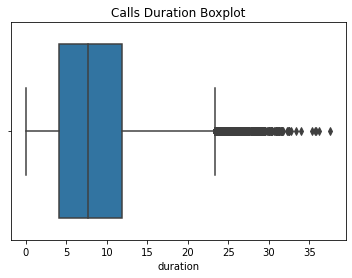

In [428]:
sns.boxplot(x=calls['duration'])
plt.title('Calls Duration Boxplot')
plt.show()

In [429]:
Q1 = calls['duration'].quantile(0.25)
Q3 = calls['duration'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

Q1:  4.15
Q3:  11.82
IQR:  7.67


In [430]:
bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + 1.5 * IQR
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

min:  0
max:  23.325


In [431]:
calls_outliers = calls.query('duration > @top_cutoff')
len(calls_outliers) / len(calls) * 100

0.8187482529463216

- The top cutoff is 23 minutes. There is less than 1% users with extreme call usage

In [432]:
calls.sample(5)

,id,user_id,call_date,duration,day,month,year
103570,1365766,1365,2018-10-09,12.67,Tuesday,10,2018
15369,1061311,1061,2018-07-14,13.67,Saturday,7,2018
70593,1251604,1251,2018-07-26,0.72,Thursday,7,2018
15285,1061227,1061,2018-08-30,3.44,Thursday,8,2018
118012,1412296,1412,2018-08-15,4.70,Wednesday,8,2018


In [433]:
internet.head()

,id,user_id,session_date,mb_used
0,100013,1000,2018-12-29,89.86
1,1000204,1000,2018-12-31,0.00
2,1000379,1000,2018-12-28,660.40
3,1000413,1000,2018-12-26,270.99
4,1000442,1000,2018-12-27,880.22


In [434]:
internet['mb_used'].value_counts()

0.00      13747
414.46        8
435.77        8
417.46        7
313.79        7
          ...  
638.12        1
217.39        1
683.90        1
243.97        1
563.11        1
Name: mb_used, Length: 57624, dtype: int64

- There is 0 mb used. We will remove the internet sessions with 0 mb used since they don't reflect usage.

In [435]:
len(internet.loc[internet['mb_used']==0]) / len(internet) * 100

13.11423801574052

- 13% of 0 mb_used will be dropped

In [436]:
internet = internet.loc[internet['mb_used']>0]

- Checking outliers

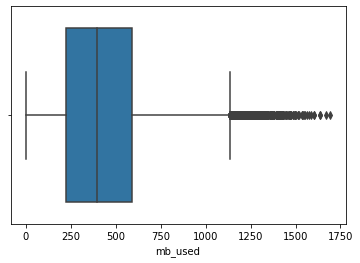

In [437]:
sns.boxplot(x=internet['mb_used'])

In [438]:
Q1 = internet['mb_used'].quantile(0.25)
Q3 = internet['mb_used'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + 1.5 * IQR
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

Q1:  223.38
Q3:  588.3675000000001
IQR:  364.98750000000007
min:  0
max:  1135.84875


In [439]:
internet_outliers = internet.query('mb_used > @top_cutoff')
len(internet_outliers) / len(internet) * 100

0.7158699137003448

- The top boxplot is 1135 mb. There is less than 1% users with extreme internet usage. These outliers are good since there are users that can bring extra fees.

In [440]:
messages.head()

,id,user_id,message_date
0,1000125,1000,2018-12-27
1,1000160,1000,2018-12-31
2,1000223,1000,2018-12-31
3,1000251,1000,2018-12-27
4,1000255,1000,2018-12-26


- make string lower case

In [441]:
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()

In [442]:
users['days_before_churn'] = np.where(users['churn_date'].isna() == False, (users['churn_date']-users['reg_date']).dt.days, np.nan)

In [443]:
users['made_calls'] = np.where(users['user_id'].isin(calls['user_id']) == True, 1, 0)

In [444]:
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,has_churned,days_before_churn,made_calls
240,1240,drema,lopez,61,"baton rouge, la msa",2018-03-18,surf,NaT,0,NaN,1
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaT,0,NaN,1
264,1264,jessie,hill,69,"los angeles-long beach-anaheim, ca msa",2018-05-03,ultimate,NaT,0,NaN,1
204,1204,sherly,levy,44,"chicago-naperville-elgin, il-in-wi msa",2018-08-20,ultimate,NaT,0,NaN,0
374,1374,ching,watts,55,"louisville/jefferson county, ky-in msa",2018-02-14,surf,NaT,0,NaN,1


In [445]:
users['made_calls'].value_counts()

1    481
0     19
Name: made_calls, dtype: int64

- Rounded up calls duration and internet mb_used

In [446]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
internet['gb_used'] = np.ceil(internet['mb_used']).astype(int)

### Q1. The number of calls made and minutes used per month <a class="anchor" id="q1"></a>

In [447]:
calls_usage = calls.groupby(['user_id','month']).agg({'duration':'sum','id':'count'}).rename(columns={'duration':'Minutes Used per month','id':'Calls Made'})
calls_usage

Minutes Used per month  Calls Made
user_id month                                    
1000    12                        124          16
1001    8                         182          22
        9                         315          38
        10                        393          47
        11                        426          49
...                               ...         ...
1498    12                        339          32
1499    9                         346          35
        10                        385          41
        11                        308          39
        12                        496          56

[2256 rows x 2 columns]

### Q2. The number of text messages sent per month <a class="anchor" id="q2"></a>

In [448]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [449]:
messages_usage = messages.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'SMS per month'})
messages_usage

SMS per month
user_id month               
1000    12                11
1001    8                 30
        9                 44
        10                53
        11                36
...                      ...
1496    9                 21
        10                18
        11                13
        12                11
1497    12                50

[1806 rows x 1 columns]

### Q3. The volume of data per month <a class="anchor" id="q3"></a>

In [450]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [451]:
# in mb
internet_usage_mb = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).rename(columns={'mb_used':'Data used per month in mb'})
internet_usage_mb

Data used per month in mb
user_id month                           
1000    12                       1901.47
1001    8                        6919.15
        9                       13314.82
        10                      22330.49
        11                      18504.30
...                                  ...
1498    12                      23137.69
1499    9                       12984.76
        10                      19492.43
        11                      16813.83
        12                      22059.21

[2277 rows x 1 columns]

In [452]:
# in gb
internet_usage = np.ceil(internet.groupby(['user_id','month'])['mb_used'].sum()/1024).astype(int).to_frame().rename(columns={'mb_used':'Data used per month in gb'})
internet_usage

Data used per month in gb
user_id month                           
1000    12                             2
1001    8                              7
        9                             14
        10                            22
        11                            19
...                                  ...
1498    12                            23
1499    9                             13
        10                            20
        11                            17
        12                            22

[2277 rows x 1 columns]

### Q4. The monthly revenue from each user <a class="anchor" id="q4"></a>
(subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan) 

Steps:
- Combine all previous dataframes to one
- Find per user, the plan they have
- check for each parameter if they used more than they should and calculate it

In [453]:
user_plan = users[['user_id','plan']]
user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


In [454]:
users_usage = pd.concat([calls_usage, messages_usage, internet_usage], axis=1).reset_index()
users_usage

,user_id,month,Minutes Used per month,Calls Made,SMS per month,Data used per month in gb
0,1000,12,124.0,16.0,11.0,2.0
1,1001,8,182.0,22.0,30.0,7.0
2,1001,9,315.0,38.0,44.0,14.0
3,1001,10,393.0,47.0,53.0,22.0
4,1001,11,426.0,49.0,36.0,19.0
...,...,...,...,...,...,...
2288,1498,12,339.0,32.0,NaN,23.0
2289,1499,9,346.0,35.0,NaN,13.0
2290,1499,10,385.0,41.0,NaN,20.0
2291,1499,11,308.0,39.0,NaN,17.0


In [455]:
users_usage = users_usage.merge(user_plan, on='user_id')
users_usage.columns= ['user_id','month','minutes','calls','sms','gb_used','plan']

In [456]:
users_usage

,user_id,month,minutes,calls,sms,gb_used,plan
0,1000,12,124.0,16.0,11.0,2.0,ultimate
1,1001,8,182.0,22.0,30.0,7.0,surf
2,1001,9,315.0,38.0,44.0,14.0,surf
3,1001,10,393.0,47.0,53.0,22.0,surf
4,1001,11,426.0,49.0,36.0,19.0,surf
...,...,...,...,...,...,...,...
2288,1498,12,339.0,32.0,NaN,23.0,surf
2289,1499,9,346.0,35.0,NaN,13.0,surf
2290,1499,10,385.0,41.0,NaN,20.0,surf
2291,1499,11,308.0,39.0,NaN,17.0,surf


In [457]:
users_usage.isnull().sum()

user_id      0
month        0
minutes     37
calls       37
sms        487
gb_used     16
plan         0
dtype: int64

In [458]:
# FIll missing values with 0
users_usage = users_usage.fillna(0)

In [461]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [462]:
plans.query('plan_name == "ultimate"').loc[:,'messages_included'].values[0]

1000

In [487]:
#initialize surf plan
surf_price = plans.query('plan_name =="surf"').loc[:,'usd_monthly_pay'].values[0]
surf_messages = plans.query('plan_name =="surf"').loc[:,'messages_included'].values[0]
surf_data = (plans.query('plan_name =="surf"').loc[:,'mb_per_month_included'].values[0]/1024).astype('int')
surf_minutes = plans.query('plan_name =="surf"').loc[:,'minutes_included'].values[0]
surf_price_for_gb = plans.query('plan_name =="surf"').loc[:,'usd_per_gb'].values[0]
surf_price_for_message =  plans.query('plan_name =="surf"').loc[:,'usd_per_message'].values[0]
surf_price_for_minute = plans.query('plan_name =="surf"').loc[:,'usd_per_minute'].values[0]

#initialize ultimate plan
ultimate_price = plans.query('plan_name =="ultimate"').loc[:,'usd_monthly_pay'].values[0] 
ultimate_messages = plans.query('plan_name == "ultimate"').loc[:,'messages_included'].values[0]
ultimate_data = (plans.query('plan_name =="ultimate"').loc[:,'mb_per_month_included'].values[0]/1024).astype('int')
ultimate_minutes = plans.query('plan_name =="ultimate"').loc[:,'minutes_included'].values[0]
ultimate_price_for_gb = plans.query('plan_name =="ultimate"').loc[:,'usd_per_gb'].values[0]
ultimate_price_for_message = plans.query('plan_name =="ultimate"').loc[:,'usd_per_message'].values[0]
ultimate_price_for_minute = plans.query('plan_name =="ultimate"').loc[:,'usd_per_minute'].values[0]

In [488]:
print(f"surf price : {surf_price} usd monthly")
print(f"surf messages : {surf_messages} messages")
print(f"surf data : {surf_data} gb per month")
print(f"surf minutes : {surf_minutes} minutes")
print(f"surf price for gb :{surf_price_for_gb} usd") 
print(f"surf price for message :{surf_price_for_message} usd")
print(f"surf price for minute :{surf_price_for_minute} usd")
print("\n")
print(f"ultimate price : {ultimate_price} usd monthly")
print(f"ultimate messages : {ultimate_messages} messages")
print(f"ultimate data : {ultimate_data} gb per month")
print(f"ultimate minutes : {ultimate_minutes} minutes")
print(f"ultimate price for gb :{ultimate_price_for_gb} usd") 
print(f"ultimate price for message :{ultimate_price_for_message} usd")
print(f"ultimate price for minute :{ultimate_price_for_minute} usd")

surf price : 20 usd monthly
surf messages : 50 messages
surf data : 15 gb per month
surf minutes : 500 minutes
surf price for gb :10 usd
surf price for message :0.03 usd
surf price for minute :0.03 usd


ultimate price : 70 usd monthly
ultimate messages : 1000 messages
ultimate data : 30 gb per month
ultimate minutes : 3000 minutes
ultimate price for gb :7 usd
ultimate price for message :0.01 usd
ultimate price for minute :0.01 usd


In [489]:
def revenue(row):
    gb_used = row['gb_used']
    plan = row['plan']
    minutes = row['minutes']
    messages = row['sms']
    total_gb = 0
    total_messages = 0 
    total_minutes = 0
    if plan == 'surf':
        if gb_used > surf_data:
            total_gb = (gb_used - surf_data) * surf_price_for_gb
        if minutes > surf_minutes:
            total_minutes = (minutes - surf_minutes) * surf_price_for_minute
        if messages > surf_messages:
            total_messages = (messages - surf_messages) * surf_price_for_message
        
        return total_gb + total_minutes + total_messages + surf_price

    else: # ultimate plan
        if gb_used > ultimate_data:
            total_gb = (gb_used - ultimate_data) * ultimate_price_for_gb
        if minutes > ultimate_minutes:
            total_minutes = (minutes - ultimate_minutes) * ultimate_price_for_minute
        if messages > ultimate_messages:
            total_messages = (messages - ultimate_messages) * ultimate_price_for_message
        return total_gb + total_minutes + total_messages + ultimate_price

In [520]:
users_usage['revenue'] = users_usage.apply(revenue, axis=1)

In [521]:
users_usage.head()

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
0,1000,12,124.0,16.0,11.0,2.0,ultimate,70.00
1,1001,8,182.0,22.0,30.0,7.0,surf,20.00
2,1001,9,315.0,38.0,44.0,14.0,surf,20.00
3,1001,10,393.0,47.0,53.0,22.0,surf,90.09
4,1001,11,426.0,49.0,36.0,19.0,surf,60.00


In [522]:
users_usage.sample(10)

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
1608,1348,12,779.0,72.0,56.0,14.0,surf,28.55
1819,1391,11,619.0,60.0,34.0,18.0,ultimate,70.00
704,1147,10,669.0,76.0,24.0,37.0,surf,245.07
935,1195,9,144.0,19.0,25.0,5.0,surf,20.00
348,1073,12,402.0,37.0,0.0,17.0,surf,40.00
602,1127,11,223.0,23.0,12.0,28.0,surf,150.00
2088,1451,12,425.0,41.0,49.0,13.0,ultimate,70.00
120,1032,12,761.0,79.0,20.0,14.0,ultimate,70.00
755,1157,8,389.0,48.0,0.0,16.0,surf,30.00
1813,1390,9,692.0,74.0,0.0,11.0,ultimate,70.00


In [523]:
# Most profitable users
users_usage.iloc[users_usage['revenue'].idxmax(),:]

user_id      1379
month          12
minutes      1103
calls         114
sms           126
gb_used        70
plan         surf
revenue    590.37
Name: 1756, dtype: object

In [524]:
# Less profitable users
users_usage.iloc[users_usage['revenue'].idxmin(),:]

user_id    1001
month         8
minutes     182
calls        22
sms          30
gb_used       7
plan       surf
revenue      20
Name: 1, dtype: object

In [525]:
# All users with less profitable revenue
users_usage[users_usage['revenue']==20]

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
1,1001,8,182.0,22.0,30.0,7.0,surf,20.0
2,1001,9,315.0,38.0,44.0,14.0,surf,20.0
6,1002,10,59.0,8.0,15.0,7.0,surf,20.0
8,1002,12,384.0,38.0,41.0,15.0,surf,20.0
10,1004,5,193.0,19.0,7.0,7.0,surf,20.0
...,...,...,...,...,...,...,...,...
2272,1496,8,122.0,14.0,2.0,9.0,surf,20.0
2274,1496,10,317.0,35.0,18.0,14.0,surf,20.0
2275,1496,11,308.0,32.0,13.0,9.0,surf,20.0
2282,1498,6,238.0,29.0,0.0,15.0,surf,20.0


In [526]:
# Total Revenue
users_usage['revenue'].sum()

147557.18

In [527]:
# Total Revenue per plan
users_usage.groupby('plan')['revenue'].sum()

plan
surf        95491.18
ultimate    52066.00
Name: revenue, dtype: float64

### Conclusion

- All date data type are fixed to datetime
- All id data type are fixed to int
- Change str to lower case
- Using groupby, we got number of calls made and minutes used per month, number of text messages sent per month,  volume of data per month
- To get the montly revenue per each user, we combine all previous dataframes to one, to find per user, the plan they have and check for each parameter if they used more than they should and calculate it by subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan
- Most profitable user is in surf plan for user_id 1379 and month 12 with revenue 596.65
- Total revenue is 147557.18 USD
- Total revenue for surf plan is 95491.18 USD and for ultimate plan is 52066 USD

## Step 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>

- Describe the customers' behavior. 
- Find the minutes, texts, and volume of data the users of each plan require per month. 
- Calculate the mean, variance, and standard deviation. 
- Plot histograms. 
- Describe the distributions.

In [528]:
users['plan'].value_counts(normalize=True) * 100

surf        67.8
ultimate    32.2
Name: plan, dtype: float64

- 67.8% customers choose Surf plan. 32.2% customers choose Ultimate plan

In [529]:
# Find the minutes, texts, and volume of data the users of each plan require per month.
status = users_usage.groupby(['plan','month']).agg({'minutes':'sum','sms':'sum','gb_used':'sum'})
status

minutes      sms  gb_used
plan     month                            
surf     1         406.0     21.0     10.0
         2        2673.0    108.0    110.0
         3        7590.0    351.0    312.0
         4       17577.0    870.0    611.0
         5       30768.0   1849.0   1087.0
         6       41836.0   2454.0   1502.0
         7       54448.0   3271.0   2042.0
         8       66438.0   4662.0   2735.0
         9       80360.0   5968.0   3238.0
         10     101846.0   8020.0   4126.0
         11     119801.0   9165.0   4650.0
         12     150680.0  12275.0   5800.0
ultimate 1         774.0     62.0     29.0
         2        2822.0    151.0    121.0
         3        3651.0    243.0    221.0
         4        7074.0    463.0    343.0
         5       11781.0    931.0    489.0
         6       17435.0   1379.0    725.0
         7       25197.0   1937.0    973.0
         8       29922.0   2732.0   1267.0
         9       37626.0   3259.0   1463.0
         10      47778.0   4181.0   1878.0
         11      56540.0   4903.0   2174.0
         12      69324.0   6796.0   2778.0

In [530]:
# Minutes mean, variance, and standard deviation.
users_usage.groupby(['plan'])['minutes'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,428.749523,54968.279461,234.453150
ultimate,430.450000,57844.464812,240.508762


In [531]:
 # Messages/sms mean, variance, and standard deviation.
users_usage.groupby(['plan'])['sms'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,31.159568,1126.724522,33.566717
ultimate,37.551389,1208.756744,34.767179


In [532]:
# Data / mb_used mean, variance, and standard deviation.
users_usage.groupby(['plan'])['gb_used'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,16.670693,61.58360,7.847522
ultimate,17.306944,58.83055,7.670108


In [533]:
users_usage_surf = users_usage.query('plan == "surf"')
users_usage_ultimate = users_usage.query('plan == "ultimate"')

In [534]:
users_usage_surf.head(2)

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
1,1001,8,182.0,22.0,30.0,7.0,surf,20.0
2,1001,9,315.0,38.0,44.0,14.0,surf,20.0


In [535]:
users_usage_ultimate.head(2)

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
0,1000,12,124.0,16.0,11.0,2.0,ultimate,70.0
19,1006,11,10.0,2.0,15.0,3.0,ultimate,70.0


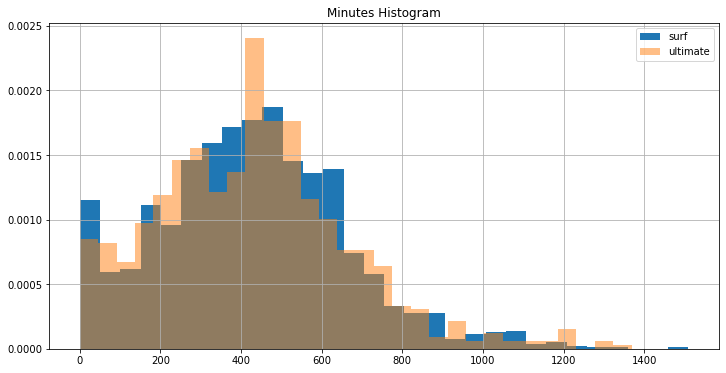

In [536]:
ax = users_usage_surf.hist(column='minutes',density=True, bins=30, figsize=(12,6))
users_usage_ultimate.hist(column='minutes',density=True, bins=30, alpha=0.5,ax =ax)
plt.legend(['surf','ultimate'])
plt.title('Minutes Histogram')
plt.show()

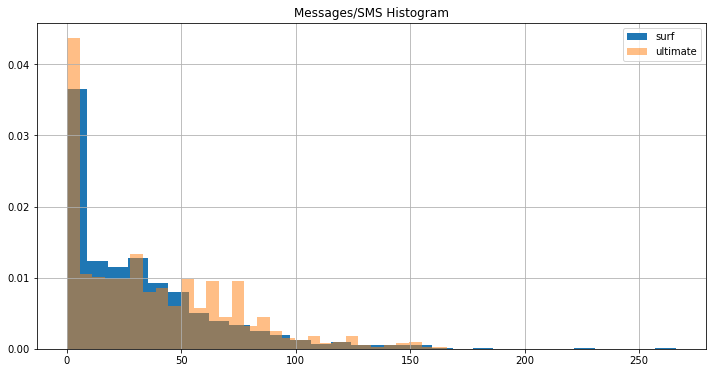

In [537]:
ax = users_usage_surf.hist(column='sms',density=True, bins=30, figsize=(12,6))
users_usage_ultimate.hist(column='sms',density=True, bins=30, alpha=0.5,ax =ax)
plt.legend(['surf','ultimate'])
plt.title('Messages/SMS Histogram')
plt.show()

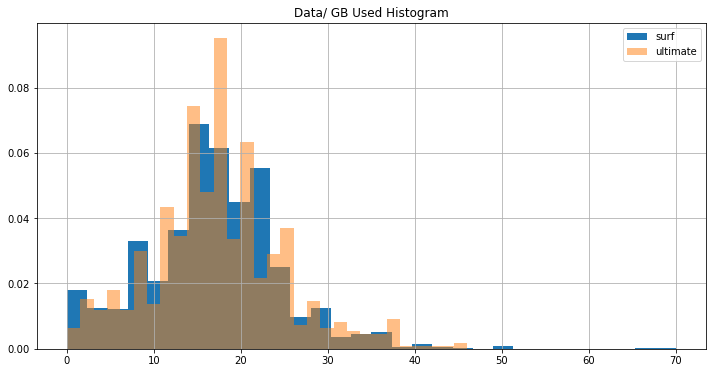

In [564]:
ax = users_usage_surf.hist(column='gb_used',density=True, bins=30, figsize=(12,6))
users_usage_ultimate.hist(column='gb_used',density=True, bins=30, alpha=0.5,ax =ax)
plt.legend(['surf','ultimate'])
plt.title('Data/ GB Used Histogram')
plt.show()

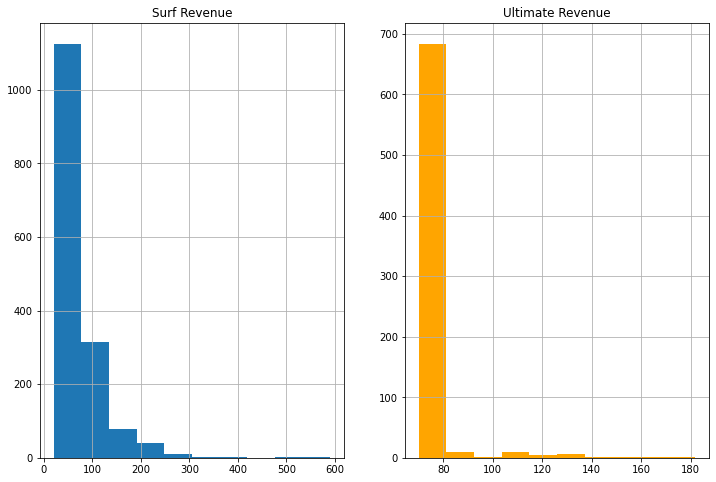

In [578]:
fig, axes = plt.subplots(1, 2)
users_usage_surf['revenue'].hist(ax=axes[0])
users_usage_ultimate['revenue'].hist(ax=axes[1], color='orange',figsize=(12,8))
axes[0].set_title('Surf Revenue')
axes[1].set_title('Ultimate Revenue')
plt.show()

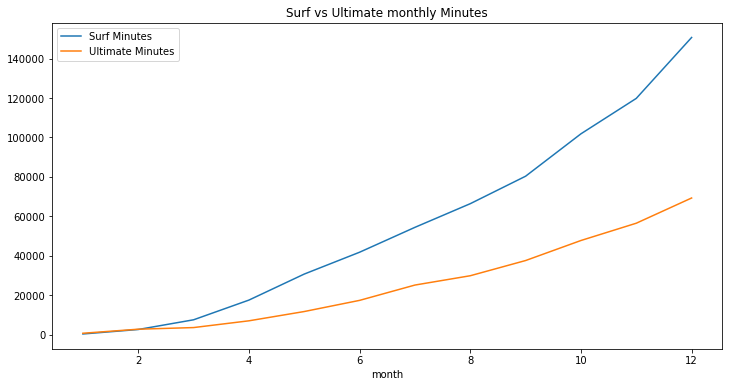

In [539]:
plt.figure(figsize=(12,6))
status.xs('surf')['minutes'].plot()
status.xs('ultimate')['minutes'].plot()
plt.legend(['Surf Minutes', 'Ultimate Minutes'])
plt.title('Surf vs Ultimate monthly Minutes')
plt.show()

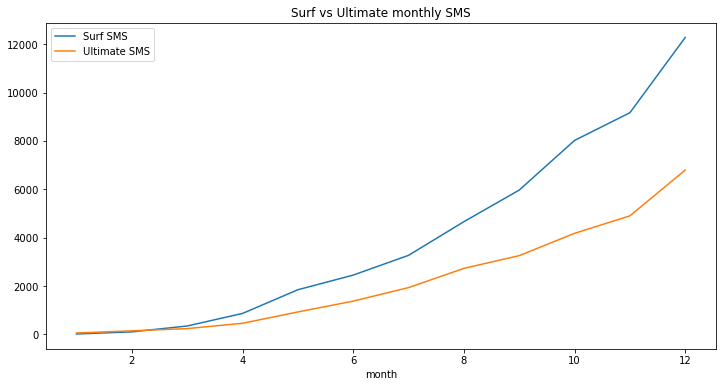

In [540]:
plt.figure(figsize=(12,6))
status.xs('surf')['sms'].plot()
status.xs('ultimate')['sms'].plot()
plt.legend(['Surf SMS', 'Ultimate SMS'])
plt.title('Surf vs Ultimate monthly SMS')
plt.show()

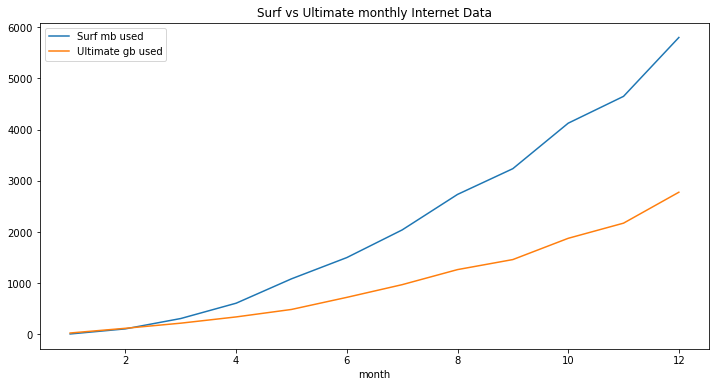

In [542]:
plt.figure(figsize=(12,6))
status.xs('surf')['gb_used'].plot()
status.xs('ultimate')['gb_used'].plot()
plt.legend(['Surf mb used', 'Ultimate gb used'])
plt.title('Surf vs Ultimate monthly Internet Data')
plt.show()

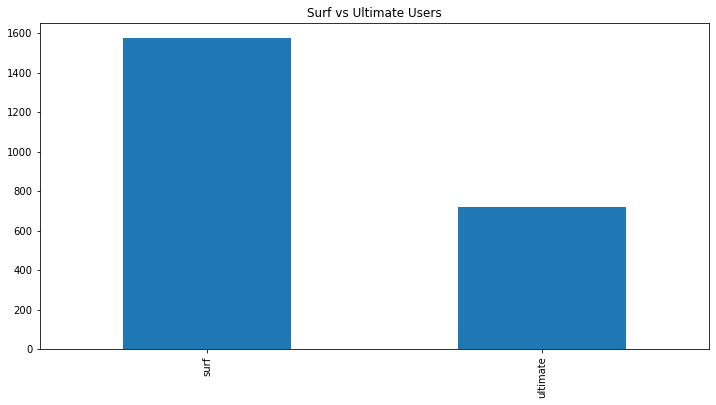

In [543]:
users_usage['plan'].value_counts().plot(kind='bar',figsize=(12,6))
plt.title('Surf vs Ultimate Users')
plt.show()

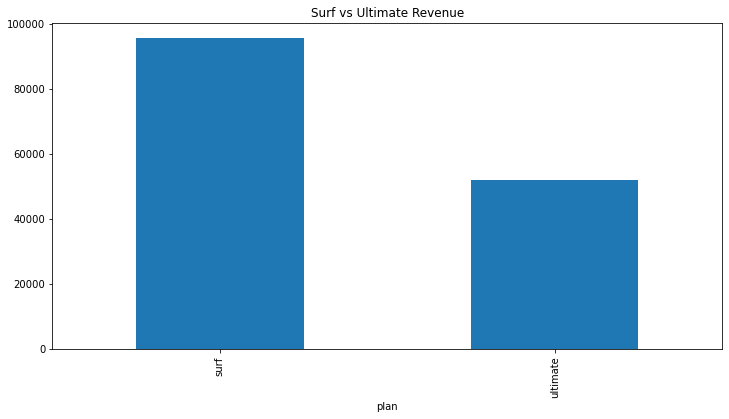

In [544]:
users_usage.groupby('plan')['revenue'].sum().plot(kind='bar', figsize=(12,6))
plt.title('Surf vs Ultimate Revenue')
plt.show()

### Conclusion
- There is more than double surf users than ultimate users.
- The histogram almost have similar distribution between surf and ultimate
- There are more surf customers that use services monthly than ultimate users. Every month the use of service increases more in surf users than the previous month.
- The minutes used per month are around 400 for both surf and ultimate. 
- Ultimate users don't use their minutes services a lot, considering their minutes average is 400 and their limit is 3000 minutes.
- Ultimate user don't use their SMS/messages services a lot, considering their messaging average is 37 and their limit is 1000 messages.
- The Data internet or mb used for surf and minutes are almost the same number.
- Surf plan brings more total revenue than ultimate plan since surf have more users than ultimate.

## Step 4. Hypotheses Testing <a class="anchor" id="hypotest"></a>

- The average revenue from users of Ultimate and Surf calling plans differs.
- The average revenue from users in NY-NJ area is different from that of the users from other regions.

### Hypothesis 1: The average revenue from users of Ultimate and Surf calling plan differs. <a class="anchor" id="hypo1"></a>

- H0 (Null Hypothesis): Average Revenue from Surf Users is equal to Average Revenue from Ultimate Users.

- HA (Alternative Hypothesis): Average Revenue from Surf Users is not equal to Average Revenue from Ultimate Users.

- Confidence level = 95%, Alpha = 0.05


In [545]:
surf_sample = users_usage[users_usage['plan']=='surf']['revenue']
surf_sample

1        20.00
2        20.00
3        90.09
4        60.00
5        60.00
         ...  
2288    100.00
2289     20.00
2290     70.00
2291     40.00
2292     90.00
Name: revenue, Length: 1573, dtype: float64

In [546]:
ultimate_sample = users_usage[users_usage['plan']=='ultimate']['revenue']
ultimate_sample

0       70.0
19      70.0
20      84.0
26      70.0
27      70.0
        ... 
2258    70.0
2259    70.0
2260    70.0
2261    70.0
2277    70.0
Name: revenue, Length: 720, dtype: float64

In [556]:
st.levene(surf_sample, ultimate_sample, center='mean')

LeveneResult(statistic=594.6026163420044, pvalue=5.91508155830786e-117)

the p-value of the test is less than the threshold value of 0.05 and hence, the sample groups do not have equal variance. equal variance = False

In [547]:
surf_sample.mean(), ultimate_sample.mean()

(60.70640813731714, 72.31388888888888)

In [548]:
alpha = 0.05
results = st.ttest_ind(
        surf_sample, 
        ultimate_sample,equal_var=False)

print('p-value: ', results.pvalue)
#Because we have two tailed, we are dividing alpha which means we have 2.5% each side.
if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  3.17039054811355e-15
We reject the null hypothesis


In [549]:
# Do ultimate users pay more than surf?

ultimate_sample.mean() > surf_sample.mean()

True

### Conclusion
- With Levene Test, the sample group do not have equal variance since the pvalue of Levene test is less than threshold of 0.05. 
- With confidence level 95%, we rejected the null hypothesis, so the average revenue from surf users is not equal to the ultimate users. 
- Ultimate users are more profitable than Surf users.

### Hypothesis 2 : The average revenue from users of Ultimate and Surf calling plan differs. <a class="anchor" id="hypo2"></a>

- HO (Null hypothesis) = The average revenue from NY-NJ users is equal to other region users 
- HA (Alternative Hypothesis) = The average revenue from NY-NJ users is not equal to other region users 
- Confidence level = 95%, Alpha = 0.05

In [558]:
users['city'].value_counts()

new york-newark-jersey city, ny-nj-pa msa          80
los angeles-long beach-anaheim, ca msa             29
dallas-fort worth-arlington, tx msa                21
chicago-naperville-elgin, il-in-wi msa             19
philadelphia-camden-wilmington, pa-nj-de-md msa    17
                                                   ..
cape coral-fort myers, fl msa                       1
stockton, ca msa                                    1
greensboro-high point, nc msa                       1
raleigh-cary, nc msa                                1
albany-schenectady-troy, ny msa                     1
Name: city, Length: 73, dtype: int64

In [559]:
is_ny_nj = users['city'].apply(lambda x: True if 'ny-nj' in x else False)
ny_nj = users[is_ny_nj]['user_id'].values.tolist()

In [560]:
ny_nj_sample = users_usage[users_usage['user_id'].isin(ny_nj)]['revenue']
other_sample = users_usage[~users_usage['user_id'].isin(ny_nj)]['revenue']

In [561]:
ny_nj_sample.mean(), other_sample.mean()

(59.921352785145906, 65.22277139874733)

In [562]:
st.levene(ny_nj_sample, other_sample, center='mean')

LeveneResult(statistic=1.841594757843591, pvalue=0.17489782767369766)

The p-value of the test is more than the threshold value of 0.05 and hence, the sample groups have equal variance. Equal Variance is True

In [563]:
alpha = 0.05
results = st.ttest_ind(ny_nj_sample, other_sample,equal_var=True)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.043557431621342436
We reject the null hypothesis


### Conclusion
- With Levene Test, the sample group have equal variance since the pvalue of Levene test is more than threshold of 0.05.
- With confidence level 95%, we rejected the null hypothesis, so the average revenue from NY-NJ users is not equal to the other users from other regions
- Other regions revenue is more profitable. 

## Step 5. Overall conclusion <a class="anchor" id="allconclusion"></a>

- Surf plan is more popular than Ultimate
- The most profitable user is user id 1379 in December in surf plan that brought revenue almost 600 USD. The less profitable user is also some surf plan users that brought revenue only 20 USD.
- Total revenue is around 144k, which surf bring more total revenue than ultimate because there are many surf users than ultimate
- Ultimate users are not fully used their services. Surf users always used more services than ultimate users. We should talk to Surf users to upgrade their plan
- Based on Hypothesis, **the Ultimate plan is more profitable than surf plan**. So we should push many surf plan users to upgrade their plans. 
- NY-NJ users are less profitable than other regions